In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style(grid=False)

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# set figure size
plt.rcParams["figure.figsize"] = (10,8)
# specify decimal places to display
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from wrangle import wrangle_manila

In [2]:
df = wrangle_manila()
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year,decade
dt,,,,,,,,,
1845-01-01,25.00,1.87,Manila,Philippines,15.27N,120.83E,1,1845,1840
1845-02-01,24.63,2.23,Manila,Philippines,15.27N,120.83E,2,1845,1840
1845-03-01,26.51,1.37,Manila,Philippines,15.27N,120.83E,3,1845,1840
1845-04-01,26.45,0.67,Manila,Philippines,15.27N,120.83E,4,1845,1840
1845-05-01,27.56,1.50,Manila,Philippines,15.27N,120.83E,5,1845,1840


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2025 entries, 1845-01-01 to 2013-09-01
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             2025 non-null   float64
 1   AverageTemperatureUncertainty  2025 non-null   float64
 2   City                           2025 non-null   object 
 3   Country                        2025 non-null   object 
 4   Latitude                       2025 non-null   object 
 5   Longitude                      2025 non-null   object 
 6   month                          2025 non-null   int64  
 7   year                           2025 non-null   int64  
 8   decade                         2025 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 158.2+ KB


In [4]:
manila = df.drop(columns=['City','Country','Latitude','Longitude'])
manila.head()

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1845-01-01,25.00,1.87,1,1845,1840
1845-02-01,24.63,2.23,2,1845,1840
1845-03-01,26.51,1.37,3,1845,1840
1845-04-01,26.45,0.67,4,1845,1840
1845-05-01,27.56,1.50,5,1845,1840


In [5]:
#168 years of data 1845-2013
manila.tail()

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
2013-05-01,29.55,0.25,5,2013,2010
2013-06-01,28.57,0.47,6,2013,2010
2013-07-01,27.27,0.60,7,2013,2010
2013-08-01,26.75,0.38,8,2013,2010
2013-09-01,26.45,0.67,9,2013,2010


# Split

In [6]:
# set train size to be 50% of total 
train_size = int(len(manila) * .5)
train_size

1012

In [7]:
# set validate size to be 30% of total 
validate_size = int(len(df) * .3)
validate_size

607

In [8]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

406

In [9]:
# validate will go from 1012 to 1012+607
validate_end_index = train_size + validate_size
validate_end_index

1619

In [10]:
# train will go from 0 to 1011
train = manila[: train_size]
# validate will go from 1012 to 1658
validate = manila[train_size:validate_end_index]
# test will include 1619 to the end
test = manila[validate_end_index:]

In [11]:
# is len of train + validate + test == length of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(manila))

True


In [12]:
#Does the first row of original df equate to the first row of train?
print(manila.head(1) == train.head(1))

            AverageTemperature  AverageTemperatureUncertainty  month  year  \
dt                                                                           
1845-01-01                True                           True   True  True   

            decade  
dt                  
1845-01-01    True  


In [13]:
#Is the last row of train the day before the first row of validate? And the same for validate to test?
pd.concat([train.tail(1), validate.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1929-04-01,27.88,0.33,4,1929,1920
1929-05-01,28.56,0.30,5,1929,1920


In [14]:
pd.concat([validate.tail(1), test.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1979-11-01,26.21,0.32,11,1979,1970
1979-12-01,24.61,0.31,12,1979,1970


In [15]:
#Is the last row of test the same as the last row of our original dataframe?
pd.concat([test.tail(1), manila.tail(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
2013-09-01,26.45,0.67,9,2013,2010
2013-09-01,26.45,0.67,9,2013,2010


In [16]:
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'month', 'year',
       'decade'],
      dtype='object')

In [17]:
temp_cols = ['AverageTemperature','AverageTemperatureUncertainty']

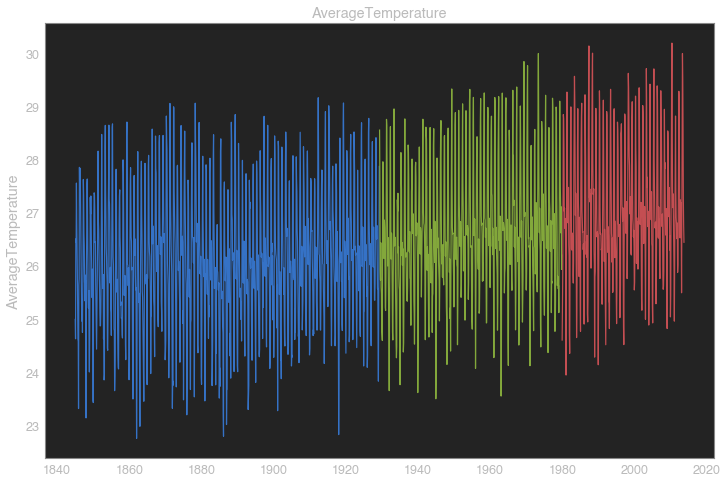

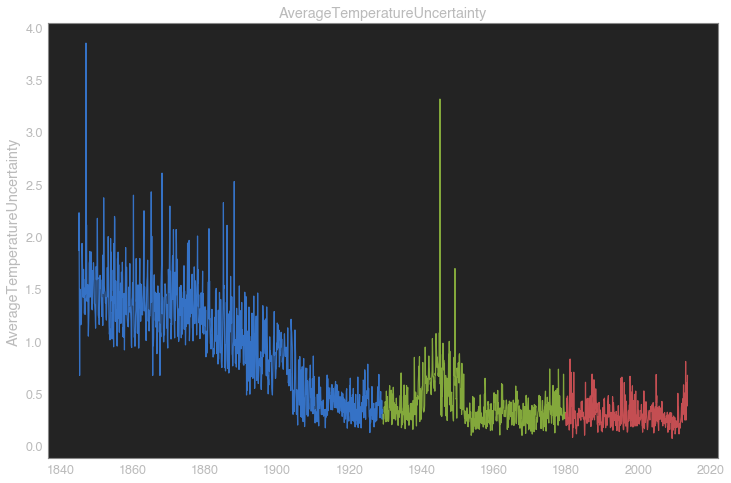

In [18]:
for col in train[temp_cols]:
    plt.figure(figsize=(12,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

array([[<AxesSubplot:title={'center':'AverageTemperature'}>,
        <AxesSubplot:title={'center':'AverageTemperatureUncertainty'}>]],
      dtype=object)

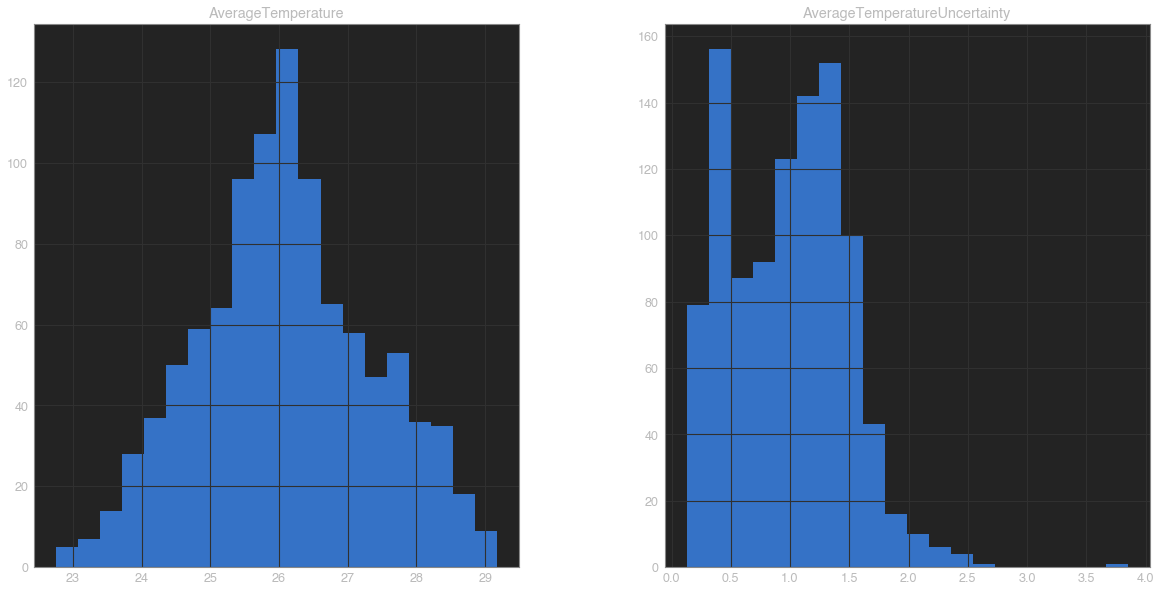

In [19]:
train[temp_cols].hist(bins=20,figsize=(20,10))

In [20]:
train.AverageTemperature.describe()

count   1012.00
mean      26.09
std        1.27
min       22.75
25%       25.26
50%       26.05
75%       26.93
max       29.17
Name: AverageTemperature, dtype: float64

<AxesSubplot:xlabel='month'>

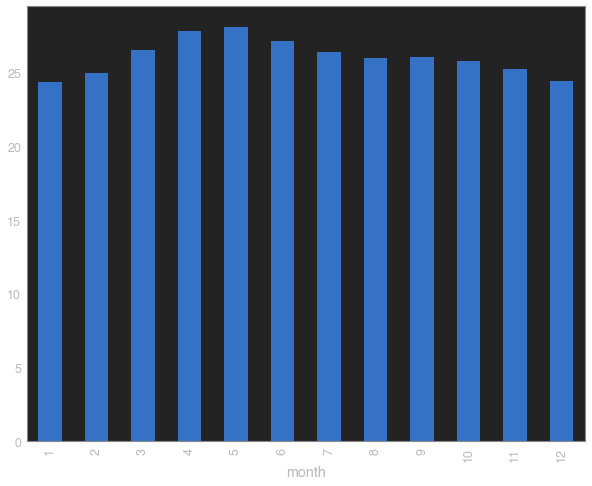

In [21]:
train.groupby('month').AverageTemperature.mean().plot.bar()

<AxesSubplot:xlabel='decade'>

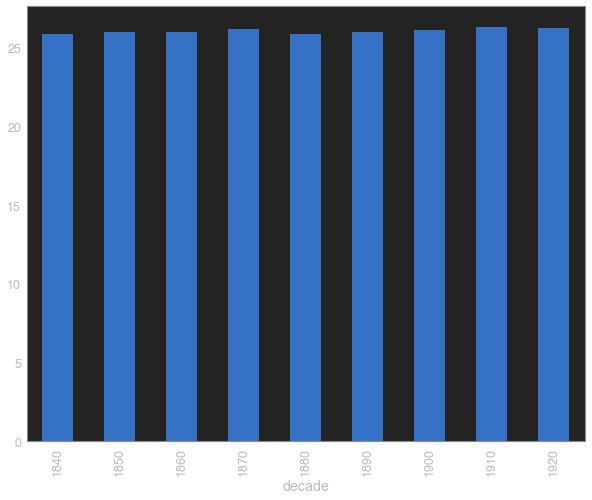

In [30]:
train.groupby('decade').AverageTemperature.mean().plot.bar()

<AxesSubplot:xlabel='month'>

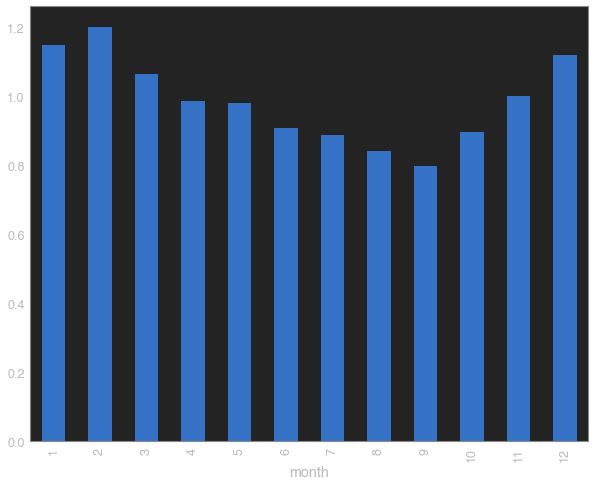

In [22]:
train.groupby('month').AverageTemperatureUncertainty.mean().plot.bar()

<AxesSubplot:xlabel='month', ylabel='AverageTemperature'>

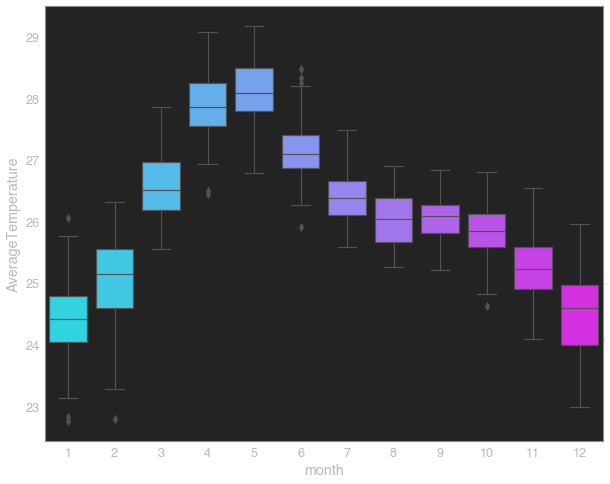

In [23]:
sns.boxplot(data = train, x='month', y='AverageTemperature', palette='cool')

<AxesSubplot:xlabel='decade', ylabel='AverageTemperature'>

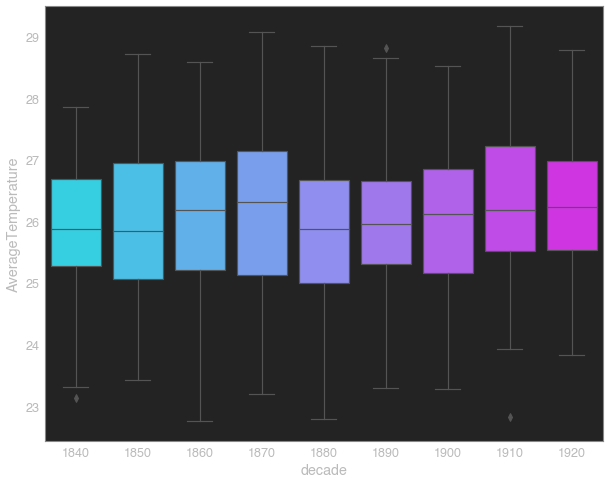

In [29]:
sns.boxplot(data = train, x='decade', y='AverageTemperature', palette='cool')

<AxesSubplot:xlabel='month', ylabel='AverageTemperatureUncertainty'>

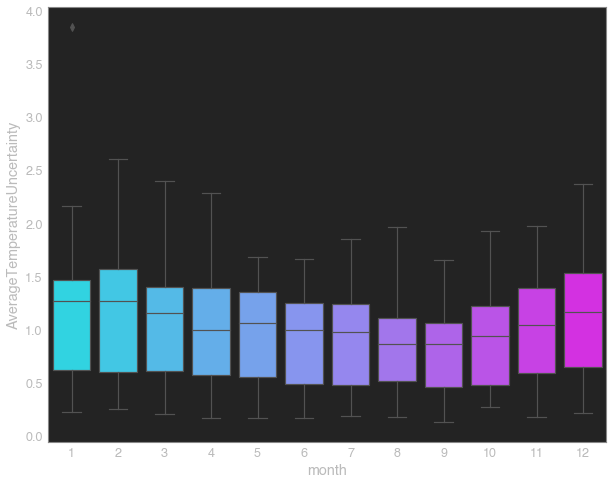

In [24]:
sns.boxplot(data = train, x='month', y='AverageTemperatureUncertainty', palette='cool')

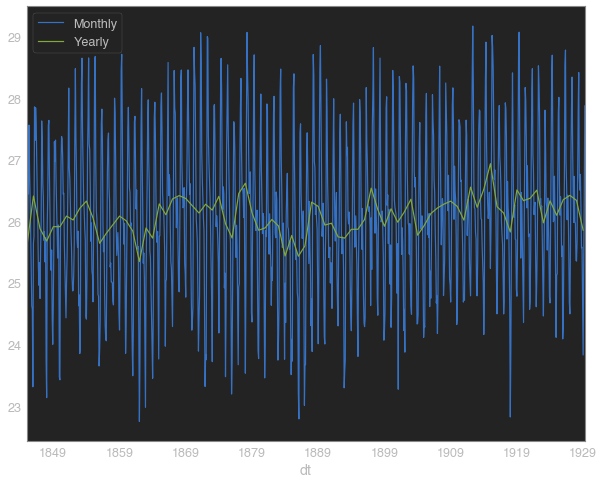

In [25]:
train.resample('M').mean().AverageTemperature.plot(label = 'Monthly')
train.resample('Y').mean().AverageTemperature.plot(label = 'Yearly')
plt.legend()

<AxesSubplot:xlabel='dt'>

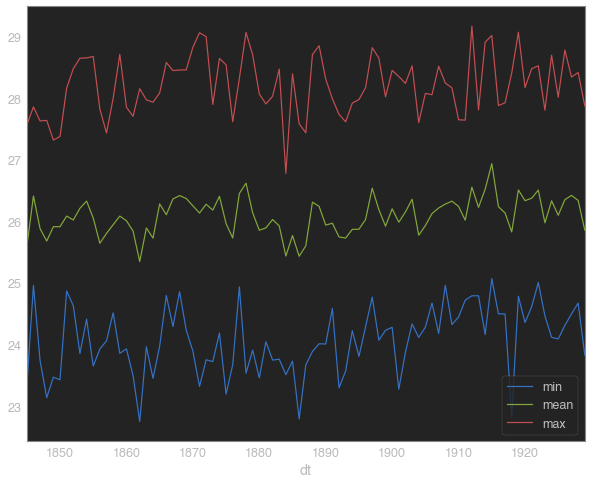

In [26]:
train.resample('Y').AverageTemperature.agg(['min','mean','max']).plot()

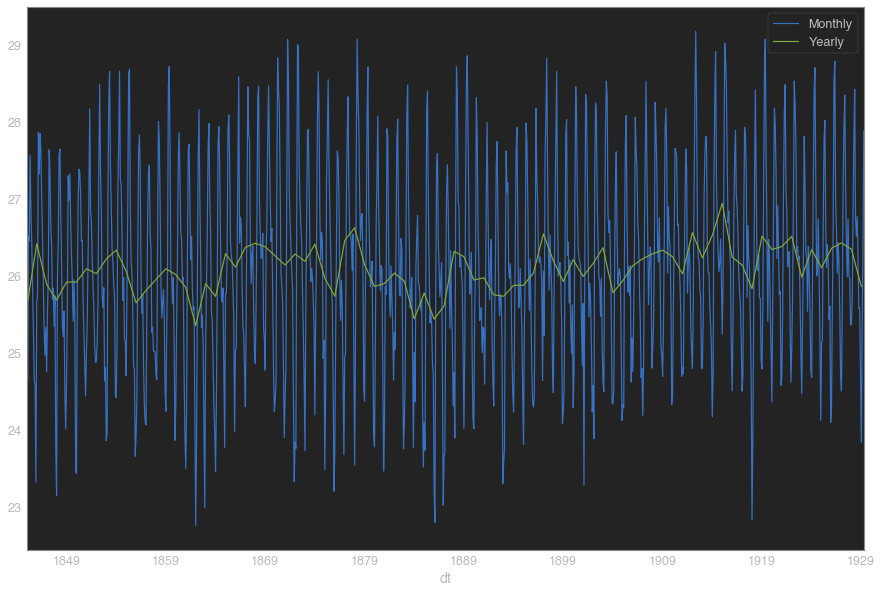

In [27]:
plt.figure(figsize=(15,10))
#train.AverageTemperature.plot(alpha=.2, label='Daily')
train.resample('M').mean().AverageTemperature.plot(label='Monthly')
train.resample('Y').mean().AverageTemperature.plot(label='Yearly')
plt.legend()